# Lab 2 - Exploring Text Data

### Eric Smith and Jake Carlson

## Introduction
For this lab we will be examining questions and answers on the popular programming Q&A website, Stack Overflow. Stack Overflow allows programmers who are stuck on a problem ask the community about ways to resolve or circumvent said problem. This helps people write more accurate code faster. However, the community can be pretty hard on those who do not fully understand their question or are disrespectful. It could also be the case that the few developers who have experience with a problem similar to yours are not on the website when you post your question. If too much time passes, your post may be burried forever. This makes for some interesing questions. When should you make your post so that it has the highest chance of being answered? Are there specific keywords or phasing that encourage other programmers to answer your questions? Are there specific languages that have their questions answered faster than others? These are questions we will be exploring in this lab.

## Business Understanding

### Motivations
Stack Overflow is a go-to resource for developers. Questions are often distilled down to a single block of code that is easily digestible, and can be matched to the question you came to the site for. However, if you're truly stuck on something, it can seem like an eternity of waiting before someone responds to your question, and sometimes, it may not be answered at all. If you're working in industry and spending a lot of time waiting for a question to be answered, you could fall behind schedule and miss deadlines. These delays could cost your company a great deal in lost revenue and tech debt. Therefore, accurately predicting the amount of time to get a question answered can be seen as a valuable project management tool.

### Objectives
It would be useful if you could predict how quickly your question will be answered if you post it at various times through out the day. For a prediction tool like this to be useful, we want something that is 80-95% accurate in predicting when a question will be answered by. As a project manager, you want your developers to be asking questions that are concise and respectful. Therefore, a tool that could recommend keywords to add to your post to make it more attractive, and provide you with approximate gains in time for reformatting, would also be a valuable project management tool.

## Data Understanding

### Data Attributes
The following is a list of attributes in the data, their data types, and a brief description of the attribute.

#### Questions
- **Id** (nominal): A unique identifier for each question
- **OwnerUserId** (nominal): A unique identifier for the person who posted the question
- **CreationDate** (ordinal): A timestamp of when the question was posted
- **ClosedDate** (ordinal): A timestamp of when the question was closed, if the question wasn't closed this field is NaN
- **Score** (ratio): The number of upvotes a post has
- **Title** (text): A title for the question
- **Body** (text): The question body

#### Answers
- **Id** (nominal): A unique identifier for each answer
- **OwnerUserId** (nominal): A unique identifier for the person who posted the answer
- **CreationDate** (ordinal): A timestamp of when the answer was posted
- **ParentId** (nominal): The unique identifier of the question this answer is for
- **Score** (ratio): The number of upvotes an answer has
- **Body** (text): The answer body

#### Tags
- **Id** (nominal): The *Id* of the question the tag is associated with
- **Tag** (nominal): The tag a question has been assigned

## Data Quality

In [2]:
import numpy as np
import pandas as pd

In [2]:
# read data
df = pd.read_csv('./data/Questions.csv', encoding='ISO-8859-1')

In [3]:
df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
Id              1264216 non-null int64
OwnerUserId     1249762 non-null float64
CreationDate    1264216 non-null object
ClosedDate      55959 non-null object
Score           1264216 non-null int64
Title           1264216 non-null object
Body            1264216 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


Trial and error has shown us that 1,264,000 elements is too many to work with. Therefore, we will use a random sample to reduce our data set size to 12,000 elements.

In [5]:
df = df.sample(n=12000, replace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 231906 to 234393
Data columns (total 7 columns):
Id              12000 non-null int64
OwnerUserId     11841 non-null float64
CreationDate    12000 non-null object
ClosedDate      508 non-null object
Score           12000 non-null int64
Title           12000 non-null object
Body            12000 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 750.0+ KB


The body of each question is formatted in HTML, so we will need to parse through each body and remove the HTML tags. We also need to replace HTML entities with their character representations. Finally, many questions have accompanying code blocks, so we will parse out the code blocks into a new attribute for each entry.

In [6]:
from bs4 import BeautifulSoup
import html
import re

# compile regexes
tag_re = re.compile('<[^<]+?>')
newline_re = re.compile('\n+')

def clean_html(body_text):
    soup = BeautifulSoup(body_text, 'html.parser')
    code_tags = soup.findAll('code')
    code_text = ""
    
    # unescape html entities
    body_text = html.unescape(body_text)
    
    # remove code blocks, saving blocks to new string
    for c in code_tags:
        body_text = body_text.replace("<code>{}</code>".format(c.string),'')
        if c.string:
            code_text += c.string

    # remove remaining tags and multiple newlines
    body_text = tag_re.sub('', body_text)
    body_text = newline_re.sub('\n', body_text)
    
    return body_text, code_text

as_list = df.Body.tolist()
body_list = []
code_list = []
for i in range(len(as_list)):
    body_text, code_text = clean_html(as_list[i])
    body_list.append(body_text)
    code_list.append(code_text)

# update body column
df = df.assign(Body=body_list)
# add code column
df = df.assign(Code=code_list)
df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Code
231906,8684820,1118172.0,2011-12-30T22:50:57Z,NaN,8,Scale HTML canvas to browser window size but d...,Is there a way to scale your HTML canvas to th...,
527250,18304620,1590705.0,2013-08-18T23:23:46Z,NaN,1,OrchardCMS Custom Forms and lookup fields,I can create custom form with Orchard Custom f...,
1096958,35749150,2726664.0,2016-03-02T13:53:23Z,NaN,0,Subtract working days from a date using Javasc...,I'd like to use a Javascript within my zapier....,
860951,28891250,2869332.0,2015-03-06T02:07:23Z,2015-03-06T04:49:50Z,0,Specifying Side Borders on Individual Cells in...,I've made a program for entering Sudoku puzzle...,
221233,8326860,22693.0,2011-11-30T13:41:59Z,NaN,1,Wrapping any SQL Server 2008 statement with sk...,"Given any statement, I would like to wrap it ...",SELECTpublic override string WrapSelectSqlWith...


With the HTML tags removed and the code isolated, the question body is much cleaner. 

In [7]:
df_ans = pd.read_csv('./data/Answers.csv', encoding='ISO-8859-1')
df_ans.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [8]:
df_ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014516 entries, 0 to 2014515
Data columns (total 6 columns):
Id              int64
OwnerUserId     float64
CreationDate    object
ParentId        int64
Score           int64
Body            object
dtypes: float64(1), int64(3), object(2)
memory usage: 92.2+ MB


We will select only the answers whose question is in our random sample of questions.

In [9]:
# get the answers that pertain to our sample of 12,000 questions
ids = df.Id.unique()
df_ans = df_ans[df_ans.ParentId.isin(ids)]
df_ans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18864 entries, 433 to 2014432
Data columns (total 6 columns):
Id              18864 non-null int64
OwnerUserId     18740 non-null float64
CreationDate    18864 non-null object
ParentId        18864 non-null int64
Score           18864 non-null int64
Body            18864 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 1.0+ MB


We will clean the answers data frame using the same function as the questions data frame.

In [10]:
as_list = df_ans.Body.tolist()
body_list = []
code_list = []
for i in range(len(as_list)):
    body_text, code_text = clean_html(as_list[i])
    body_list.append(body_text)
    code_list.append(code_text)

# update body column
df_ans = df_ans.assign(Body=body_list)
# add code column
df_ans = df_ans.assign(Code=code_list)
df_ans.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,Code
433,11436,1341.0,2008-08-14T18:09:59Z,11430,10,"Actually it ships with .NET 3.5 SP1. So yes, ...",
601,15128,1818.0,2008-08-18T19:45:09Z,11430,3,"I swear this isn't being pedantic, but is an i...",
1078,25747,1709.0,2008-08-25T07:54:46Z,25730,7,I have had good experiences with Rational Puri...,
1081,25828,45603.0,2008-08-25T09:52:34Z,25730,1,Try Jochen Kalmbach's Memory Leak Detector on ...,
1082,25831,891.0,2008-08-25T10:03:23Z,25730,32,"I personally use Visual Leak Detector, though ...",


Now lets add another column for the time in minutes it took to get the question answered. Because a majority of the questions are not marked 'closed', we will consider the highest rated answer as the closing answer. 

We will then use the difference in time between the question being posted and the closing answer being posted as the "duration".

In [11]:
# adapted from https://stackoverflow.com/questions/2788871/date-difference-in-minutes-in-python
from datetime import datetime
import time

fmt = '%Y-%m-%dT%H:%M:%SZ'
def get_minutes_diff(timestamp1, timestamp2):
    d1 = datetime.strptime(timestamp1, fmt)
    d2 = datetime.strptime(timestamp2, fmt)
    
    # convert to unix timestamp
    d1_ts = time.mktime(d1.timetuple())
    d2_ts = time.mktime(d2.timetuple())
    
    # convert to minutes
    return int(d2_ts - d1_ts) / 60

durations = []
for i, row in df.iterrows():
    answer = df_ans[ df_ans.ParentId == row.Id ]
    answer = answer[ answer.Score == answer.Score.max() ]
    answer_time = answer.CreationDate.values
    if len(answer_time) > 0:
        answer_time = answer_time[0]
        dur = get_minutes_diff(row.CreationDate, answer_time)
        if dur > -1: 
            df.loc[i, 'Duration'] = dur

In [12]:
df[['Id', 'Duration']].head()

,Id,Duration
231906,8684820,414.433333
527250,18304620,567.750000
1096958,35749150,6.716667
860951,28891250,NaN
221233,8326860,28.033333


Now we will load the tags and save the tags that correspond to a question in our random sample.

In [13]:
df_tags = pd.read_csv('./data/Tags.csv', encoding='ISO-8859-1')
df_tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [14]:
ids = df.Id.unique()
df_tags = df_tags[df_tags.Id.isin(ids)]
df_tags.head()

,Id,Tag
322,11430,sql-server
323,11430,sql-server-2008
717,25730,c++
718,25730,c
719,25730,visual-studio


Save the cleaned data to a persistance file for easy loading.

In [15]:
df.to_csv('./clean-data/Questions.csv', sep=',')
df_ans.to_csv('./clean-data/Answers.csv', sep=',')
df_tags.to_csv('./clean-data/Tags.csv', sep=',')

## Data Visualization

In [3]:
df = pd.read_csv('./clean-data/Questions.csv')
df_ans = pd.read_csv('./clean-data/Answers.csv')
df_tags = pd.read_csv('./clean-data/Tags.csv')

Let's start our data exploration by looking at the most frequently used tags and how many total votes are associated with those tags. We will select any tags that have more than 175 occurances in our data set. 

In [17]:
from collections import Counter

tag_counts = Counter(df_tags.Tag)

# remove tags that have less than 175 occurances
for t in list(tag_counts):
    if tag_counts[t] < 175:
        del tag_counts[t]

df_tag_counts = pd.DataFrame.from_dict(tag_counts, orient='index')

# group by tag
df_tags_by_langauge = df_tags.groupby(by=['Tag'])
num_lang = len(df_tag_counts[ df_tag_counts[0] > 300 ])

prog_languages = []

# find question ids with tag from df_tags
for tag, group in df_tags_by_langauge:
    if len(group) > 300:
        # keep track of programming languages
        prog_languages.append(tag)

# find the total number of upvotes for each language in prog_languages
vote_counts = [0 for x in prog_languages]

# for each programming language
for i, cur_lang in enumerate(prog_languages):
    cur_ids = []
    
    # get the IDs of the instances with that tag
    for index, cur_tag in df_tags.iterrows():
        if cur_tag.Tag == cur_lang:
            cur_ids.append( cur_tag.Id )
    
    # for each ID
    for id in cur_ids:
        # add to vote count at spot i
        vote_counts[i] = vote_counts[i] + df[ df.Id == id ].Score.values[0]

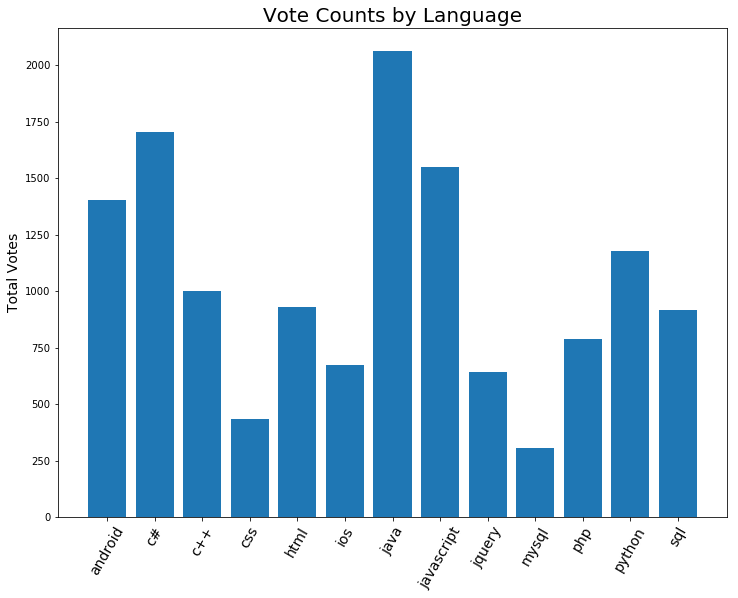

In [33]:
import matplotlib.pyplot as plt

plt.bar(range(len(vote_counts)), vote_counts)
plt.title("Vote Counts by Language", fontsize=20)
plt.xticks(range(len(vote_counts)), prog_languages, rotation='60', fontsize=14)
plt.ylabel('Total Votes', fontsize=14)

# change figure size: https://codeyarns.com/2014/10/27/how-to-change-size-of-matplotlib-plot/
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.show()

In the above histogram, we can see that questions tagged with "Java" are by far the most upvoted. This indicates that people tend to visit the Stack Overflow threads about Java the most. On the other hand, SQL questions tend to have fewer votes despite the frequency of questions about SQL.

To get a better understanding of what questions are being asked, we will look at the most common tags used on questions.

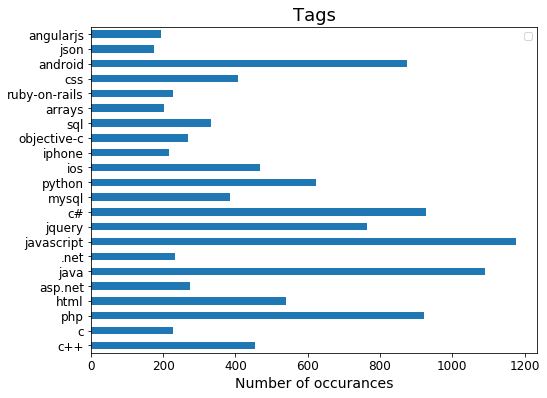

In [34]:
df_tag_counts.plot(kind='barh', fontsize=12, figsize=(8,6))
plt.xlabel('Number of occurances', fontsize=14)
plt.title('Tags', fontsize=18)
plt.legend([])
plt.show()

Above, are the most common tags assigned to a question. Most of these tags are the programming language(s) that the questions are written in. This gives us a good idea of what the most common languages people are using when they go to look for help on Stack Overflow.

Next we will look at the distribution of UserIds of the people who are answering the questions in the top langauges. We expect to see a few people answering a lot of questions, and some people who answer few questions.

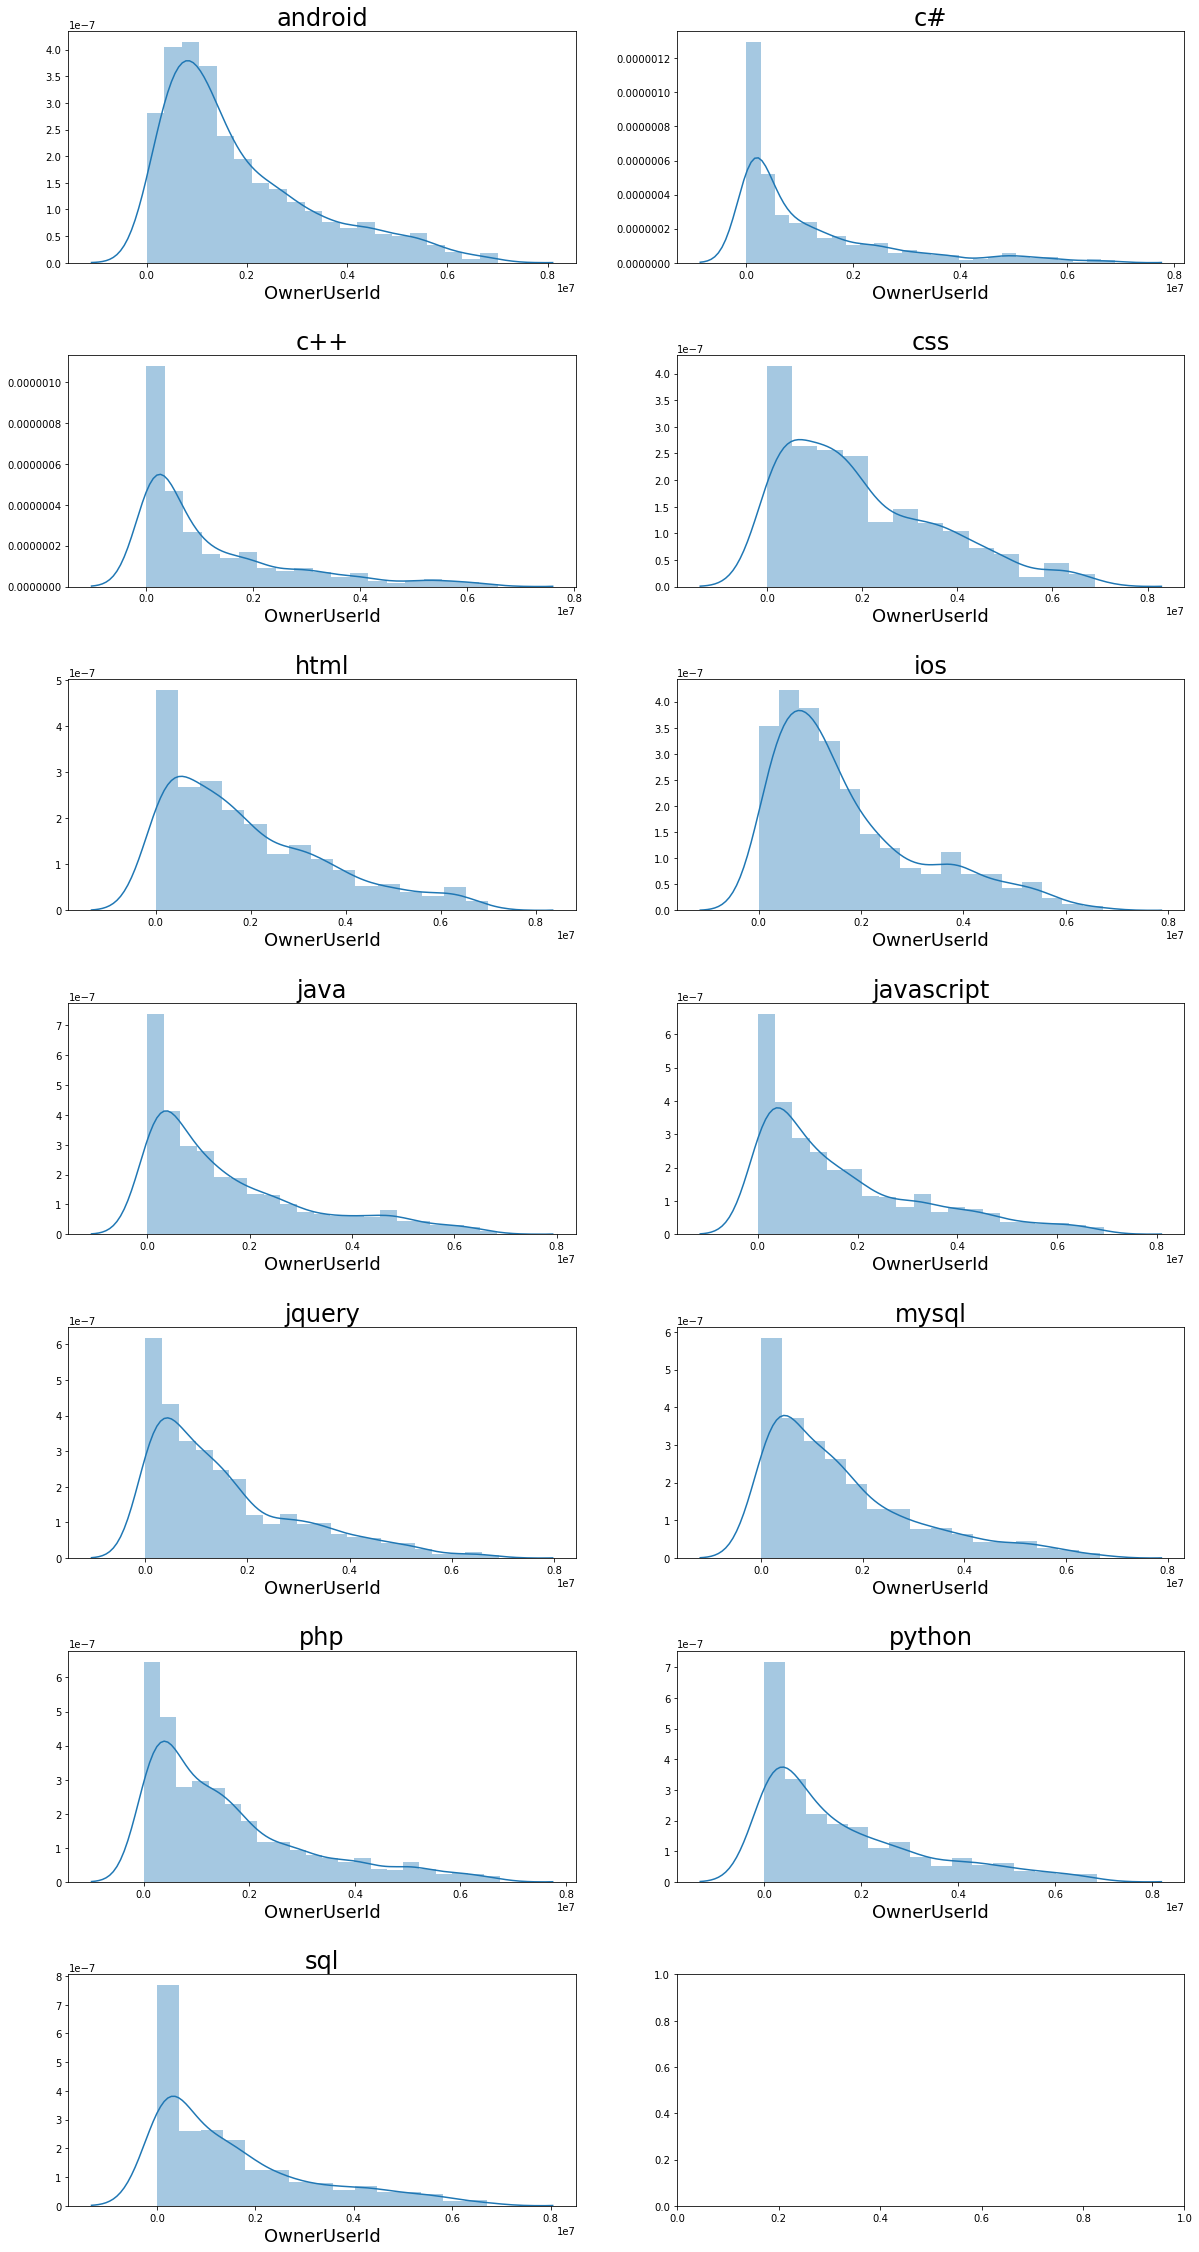

In [20]:
import seaborn as sns
import math

# get number of top langauges
num_lang = len(df_tag_counts[ df_tag_counts[0] > 300 ])

f, ax = plt.subplots(math.ceil(num_lang/2), 2, figsize=(20,40))
row_idx = 0
col_idx = 0

# find question ids with tag from df_tags
for tag, group in df_tags_by_langauge:
    if len(group) > 300:
        # find user ids in df_ans with question id
        answerer = df_ans[df_ans.ParentId.isin(group.Id)]
        answerer = answerer[np.isfinite(answerer['OwnerUserId'])]
        
        ax[row_idx, col_idx].set_title(tag, fontsize=24)
        ax[row_idx, col_idx].set_xlabel('Questions Answered', fontsize=18)
        sns.distplot(answerer['OwnerUserId'], ax=ax[row_idx, col_idx])

        # update row and column index
        if col_idx == 1:
            col_idx = 0
            row_idx += 1
        else:
            col_idx += 1

plt.subplots_adjust(hspace=0.4)
plt.show()

From this we can see how active a community is surrounding a particular language. We can see that iOS, Android, CSS, and jQuery have a lot of users who participate in answering questions, while C++ and Python have a smaller group of users who answer questions.

Next, we will look at the TF-IDF of all the computer science terms in a question. For this, we will use a list of common CS terms from [LabAutoPedia](http://www.labautopedia.org/mw/List_of_programming_and_computer_science_terms).

In [21]:
# tf-idf for most common CS terms that appear in the body
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# list of programming topics for tf-idf 
# http://www.labautopedia.org/mw/List_of_programming_and_computer_science_terms
topics = pd.read_csv('./data/CS_terms.csv', encoding='ISO-8859-1')
list_topics = [x.upper() for x in topics.Term.tolist()]

tfidf_vect = TfidfVectorizer(encoding='ISO-8859-1') 

tfidf_mat = tfidf_vect.fit_transform( df.Body.tolist() )

tfidf_mat = pd.DataFrame(data=tfidf_mat.toarray(),columns=tfidf_vect.get_feature_names())

common_terms = tfidf_mat[ [col for col in tfidf_mat.columns if col.upper() in list_topics] ]
most_common_terms = common_terms.max().sort_values()[-10:]

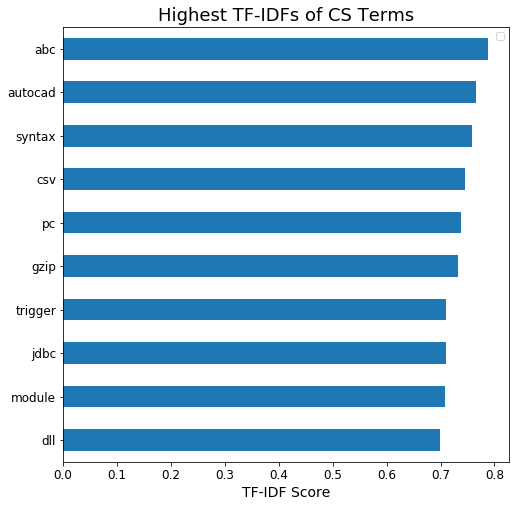

In [22]:
most_common_terms.plot(kind='barh', fontsize=12, figsize=(8,8))
plt.xlabel('TF-IDF Score', fontsize=14)
plt.title('Highest TF-IDFs of CS Terms', fontsize=18)
plt.legend([])
plt.show()

After calculating TF-IDF, we can see the occuance of words in a single question in comparison to their occurences in all the questions.

From the above graph, words like "class" or "csv" have a very high TF-IDF. That means that if these words appear in a question, they hold a reasonable significance in that question compared to all the other questions. For example, if a question contains the CS term "emulator", then that question holds a significance about the topic of emulators.

Next we will use the TF-IDF ranking to determine how similar questions for a programming language are to each other. We will compute the TF-IDF for all of the question bodies for a language and use cosine similarity to determine the distance between two questions. Then we compute the standard deviation for all of the angles generated between a question and a rest of the set to plot how much a question varies from the set.

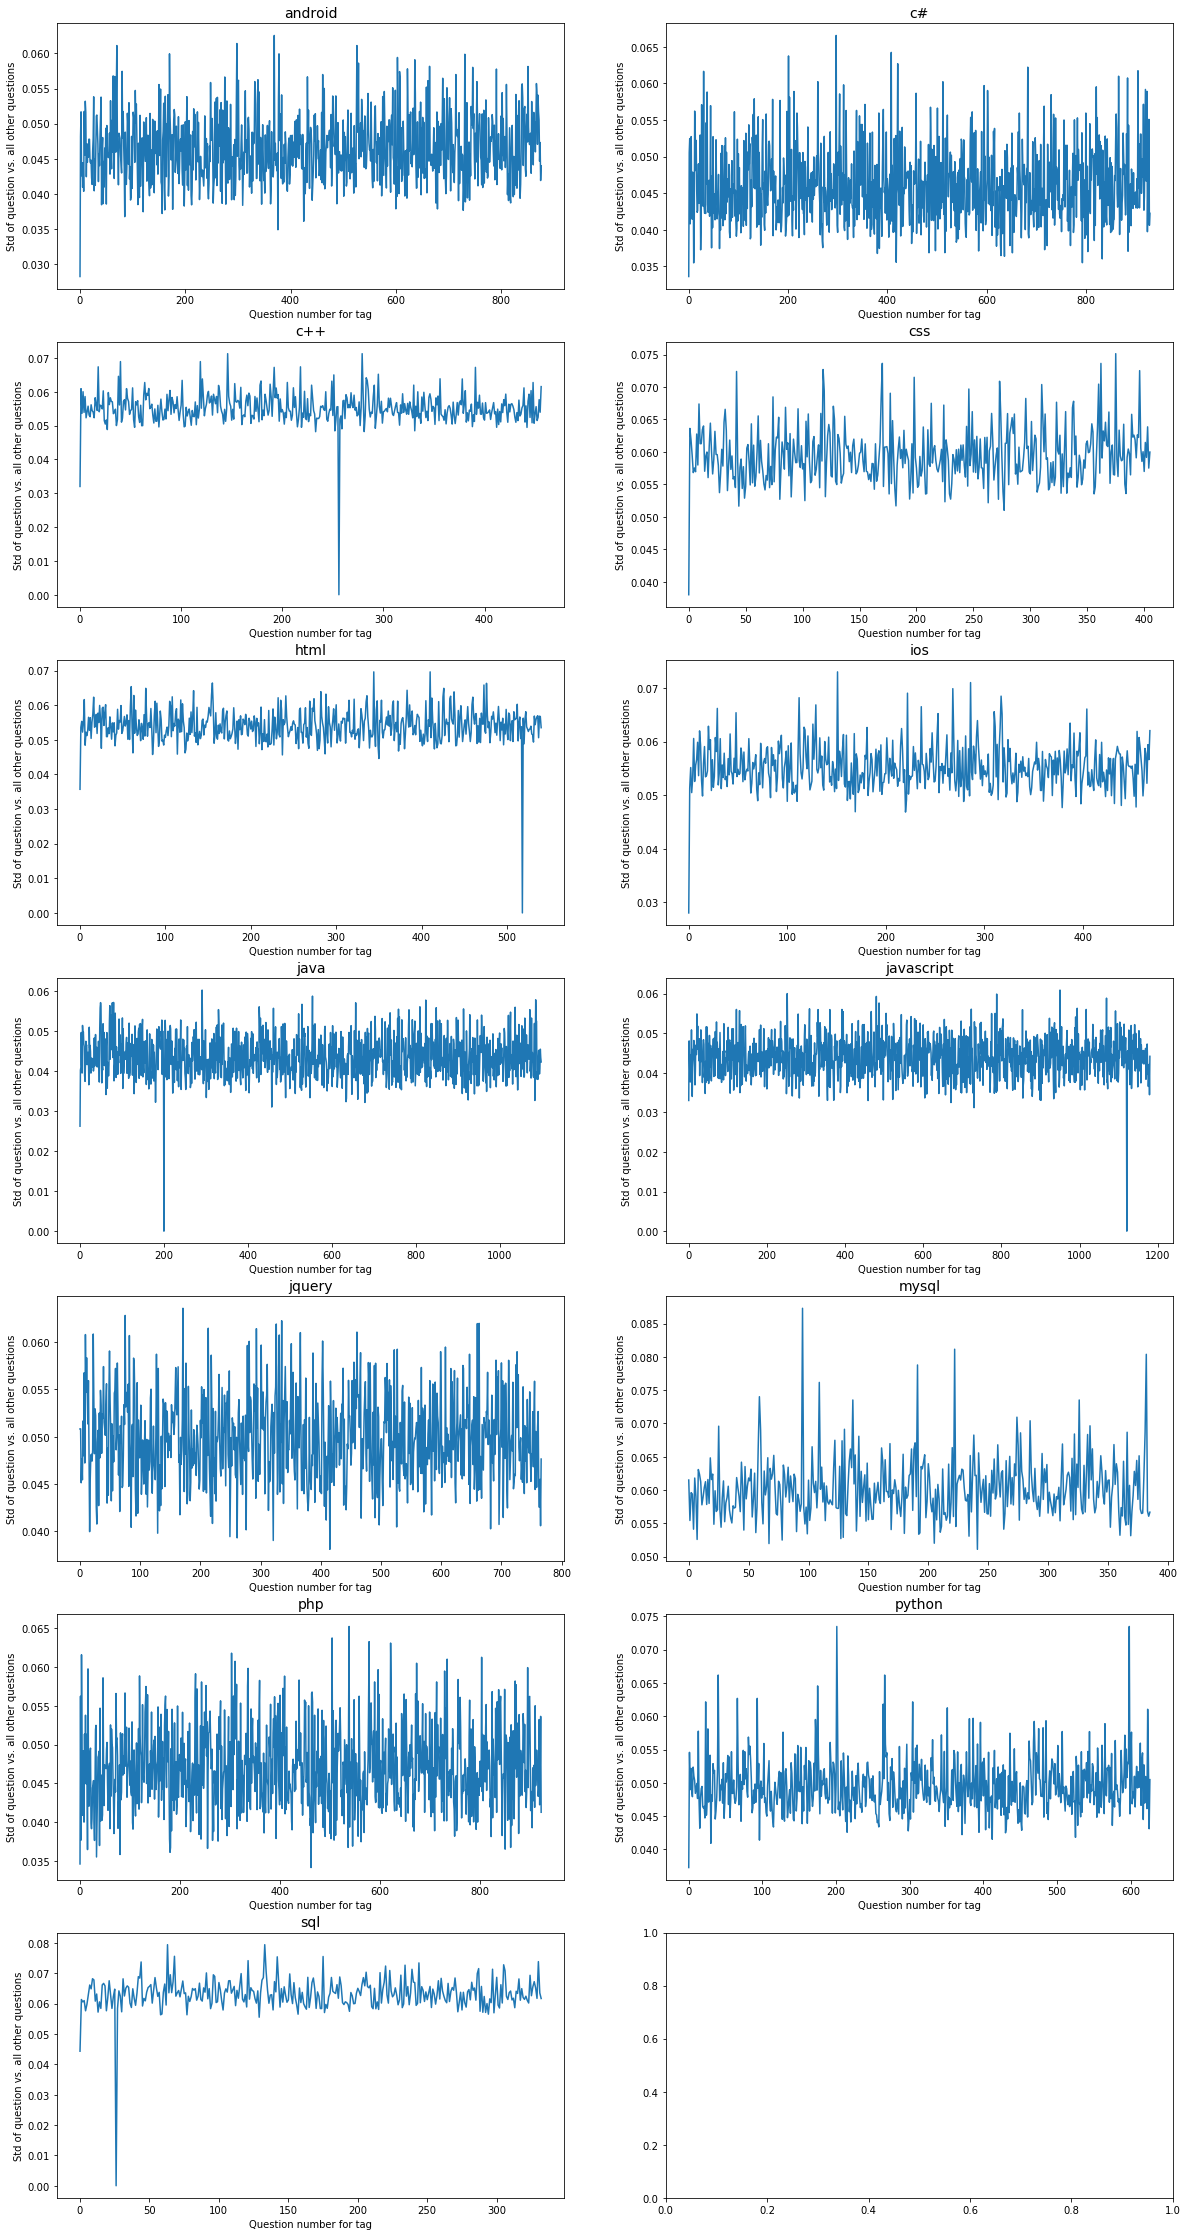

In [23]:
from sklearn.metrics.pairwise import linear_kernel

# Using cosine for document similarity:
# https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity

f, ax = plt.subplots(math.ceil(num_lang/2), 2, figsize=(20,40))
row_idx = 0
col_idx = 0

for tag, group in df_tags_by_langauge:
    if len(group) > 300:
        # find questions for the language
        questions = df[df.Id.isin(group.Id)]
        questions = questions[questions.Body.notnull()]
        tfidf_body = TfidfVectorizer().fit_transform(questions.Body)
        stdev = []
        for b in tfidf_body:
            cosine_similarities = linear_kernel(b, tfidf_body).flatten()
            # take stdev of all similarites except for the first entry, the document vs itself
            stdev.append(np.std(cosine_similarities[1:]))

        x = np.arange(0,len(stdev))
        ax[row_idx, col_idx].plot(x,stdev)
        ax[row_idx, col_idx].set_title(tag, fontsize=14)
        ax[row_idx, col_idx].set_ylabel("Std of question vs. all other questions")
        ax[row_idx, col_idx].set_xlabel("Question number for tag")
        
        # update row and column index
        if col_idx == 1:
            col_idx = 0
            row_idx += 1
        else:
            col_idx += 1
        
plt.show()

We can see that Android, C#, Java, Javascript, and jQuery questions appear to be more similar using this metric. This would indicate these questions share a common vocabulary. However, questions about CSS, HTML, iOS, and, to some extent, Python tend to have more vairance in the vocabulary used. We would expect this from CSS and HTML because of how general the domain can be for websites. This also shows how broadly Python can be applied and useful.

In [6]:
# adapted from https://stackoverflow.com/a/16359854
# 1 day = 86400 seconds
# 1 week = 604800 seconds
import sys

# put the durations into different buckets, graph the result
# only count the durations that are not null
df_durations = pd.cut(df.Duration[ df.Duration.notnull() ], 
                      bins=[-1, 3600, 86400, 604800, 2592000, sys.maxsize], 
                      labels=False)
# labels correspond to buckets of time above
labels = np.array(['Less than 1 hour', 'Less than 1 day', 'Less than 1 week', 'More than 1 week', 'More than 1 month'])
df_durations = labels[df_durations]

duration_counts = Counter(df_durations) # count each occurance

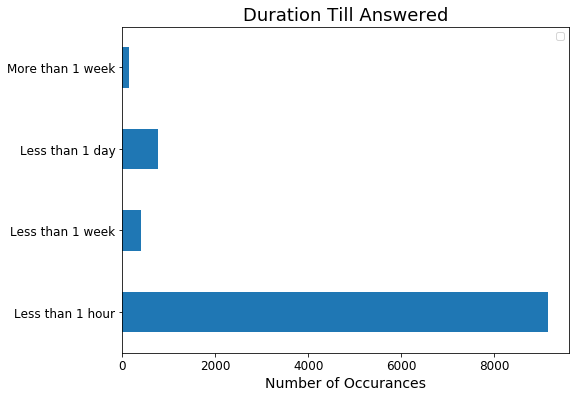

In [9]:
df_duration_counts = pd.DataFrame.from_dict(duration_counts, orient='index')
df_duration_counts.plot(kind='barh', fontsize=12, figsize=(8,6))
plt.xlabel('Number of Occurances', fontsize=14)
plt.title('Duration Till Answered', fontsize=18)
plt.legend([])
plt.show()

Above is a histogram of the time it took for a question to be "answered". (The time it took for an answer to be accepted or if there was no accepted answer, the amount of time it took for the highest rated answer to be posted.)

We can see that by a huge margin, questions get answered in less than an hour. A fact that should be promising to any software developers working on a short time frame.

But what about questions that go unanswered?

In [26]:
len(df[ df.Duration.isnull() ])

1541

In our random sample, there are only 1541 questions that are unanswered. Slightly more than the number of questions answered in less than one day.

In [10]:
df.Code[1]

# put the code into different buckets, graph the result
# count each occurance of a '\n' as a newline
                      
df_lines_of_code = pd.cut( [x.count('\n') for x in df.Code[ df.Code.notnull() ]], 
                       bins=[-1, 5, 10, 20, sys.maxsize],
                       labels=False)

# labels correspond to buckets of length above
labels = np.array(['Less than 5', '6-10', '11-20', '20+'])
df_lines_of_code = labels[df_lines_of_code]

lines_of_code_count = Counter(df_lines_of_code)

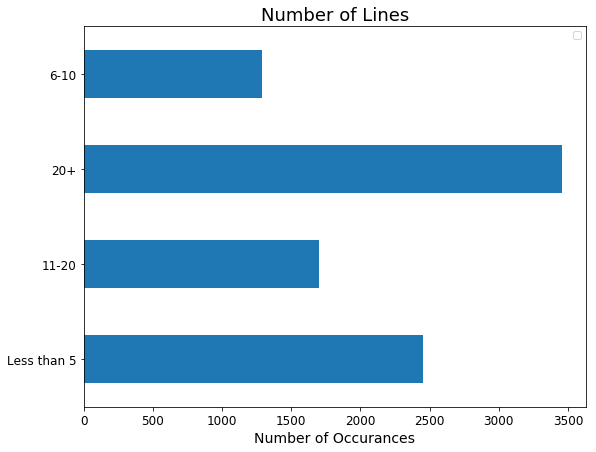

In [14]:
df_lines_of_code_count = pd.DataFrame.from_dict(lines_of_code_count, orient='index')
df_lines_of_code_count.plot(kind='barh', fontsize=12, figsize=(9,7))
plt.xlabel('Number of Occurances', fontsize=14)
plt.title('Number of Lines', fontsize=18)
plt.legend([])
plt.show()

Here, we can see what length of code is most popular in a question. A large number of questions can be presented with 5 or fewer lines of code. These questions are likely people who are looking for a quick fix to a problem issolated in a few lines of code. They have done the majority of the debugging, but are looking for help with the last step.

We see that the most common code length is 20 or more lines. These types of questions likely involve someone copying and pasting a large block of code looking for help. They have not ben able to issolate the problem, so their problem is not issolated to a small code block.

Now, does code length affect the chance of getting a question answered?

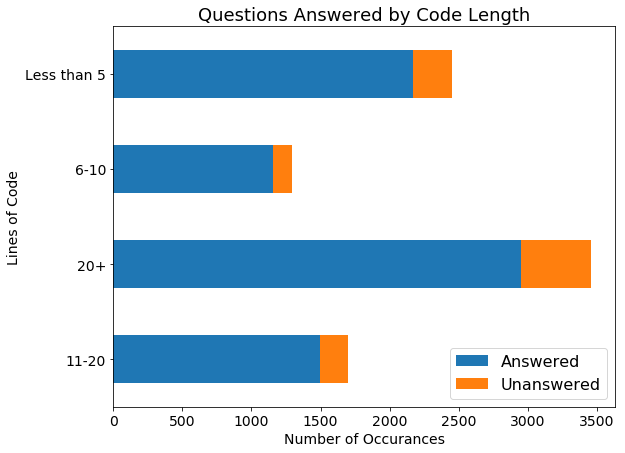

In [16]:
# stacked histogram showing percentage answered

length_vs_response = pd.crosstab([df_lines_of_code], # categories to cross tabulate
                      df.Duration[ df.Code.notnull() ].isnull()) # how to group
ax = length_vs_response.plot(kind='barh', stacked=True, fontsize=14, figsize=(9,7))
ax.set_xlabel('Number of Occurances', fontsize=14)
ax.set_ylabel('Lines of Code', fontsize=14)
ax.set_title("Questions Answered by Code Length", fontsize=18)
plt.legend(["Answered", "Unanswered"], fontsize=16)
plt.show()

We can see that the questions with the most lines of code have the greatest chance of going unanswered.

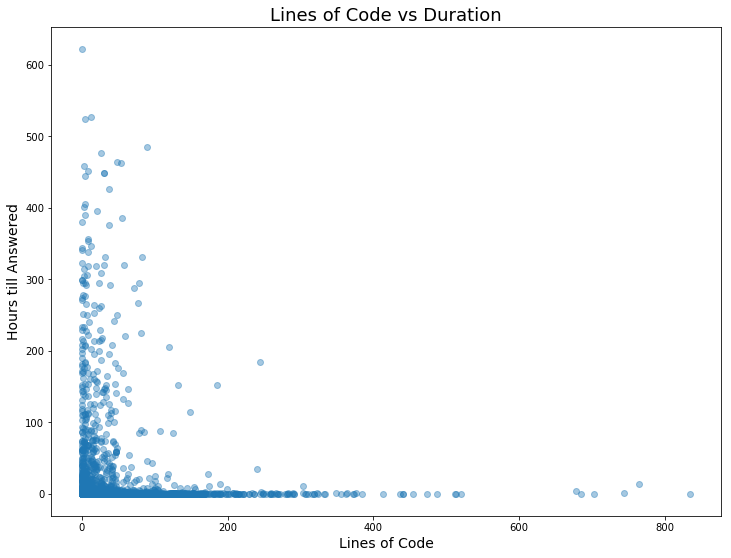

In [128]:
lines = [x.count('\n') for x in df.Code[ (df.Code.notnull() & df.Duration.notnull()) ]]
durations = [(x * 0.000277778) for x in df.Duration[ (df.Code.notnull() & df.Duration.notnull()) ]]
plt.title("Lines of Code vs Duration", fontsize=18)
plt.xlabel('Lines of Code', fontsize=14)
plt.ylabel('Hours till Answered', fontsize=14)
plt.scatter(lines, durations, alpha=0.4)
plt.show()

If we graph those instances that have both code and durations, we can see overall how lines of code affects time till answered.

Here, the clustering on the bottom left hand corner of the graph suggests a negative correlation between the lines of code a question has and how long it takes to get answered.

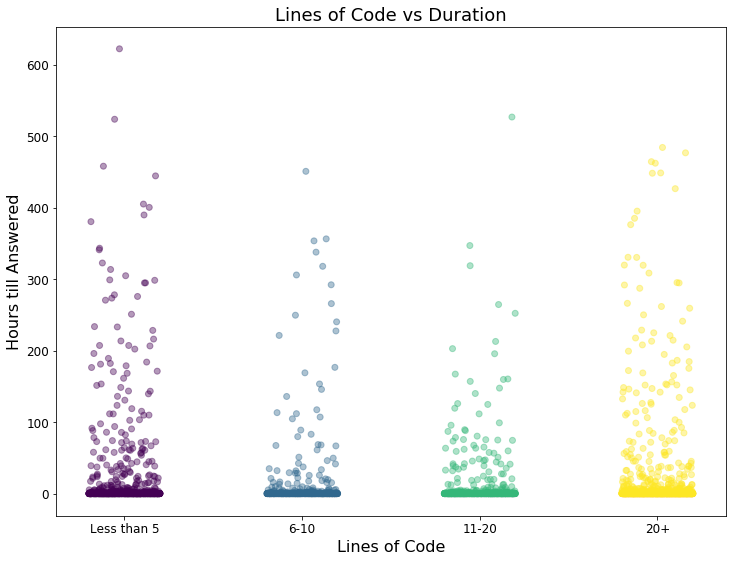

In [163]:
import random
lines = pd.cut([x.count('\n') for x in df.Code[(df.Code.notnull()) & (df.Duration.notnull())] ], 
                      bins=[-1, 5, 10, 20, sys.maxsize],
                       labels=False)
labels = np.array(['Less than 5', '6-10', '11-20', '20+'])
lines_labels = labels[lines]
colors = [str(item/255.) for item in lines]

plt.title("Lines of Code vs Duration", fontsize=18)
plt.xlabel('Lines of Code', fontsize=16)
plt.ylabel('Hours till Answered', fontsize=16)
plt.xticks([0,1,2,3], ['Less than 5', '6-10', '11-20', '20+'], fontsize=12)
plt.yticks(fontsize=12)
plt.scatter([l + random.uniform(-0.2, 0.2) for l in lines], durations, c=colors, alpha=0.4)
plt.show()

If we group by lines of code, we can see that questions with six to ten lines of code in them have the lowest variation in the amount of time they get answered. 

Since our largest classes are less than five and greater than twenty, we see the most variation in the amount of time it takes to get answered.

In [30]:
# find the average duration for each language in prog_languages
duration_counts = [0 for x in prog_languages]

# for each programming language
for i, cur_lang in enumerate(prog_languages):
    cur_ids = []
    
    # get the IDs of the instances with that tag
    for index, cur_tag in df_tags.iterrows():
        if cur_tag.Tag == cur_lang:
            cur_ids.append( cur_tag.Id )
    
    # for each ID, add up the durations
    for id in cur_ids:
        # add to duration count at spot i
        dur = df[ df.Id == id ].Duration.values[0]
        
        if math.isnan(dur) == False:
            duration_counts[i] = duration_counts[i] + dur
    
    # divide the duration by number of instances for that language
    duration_counts[i] = duration_counts[i] / len(cur_ids)
    
    # convert that duration to hours
    duration_counts[i] = duration_counts[i] * 0.000277778

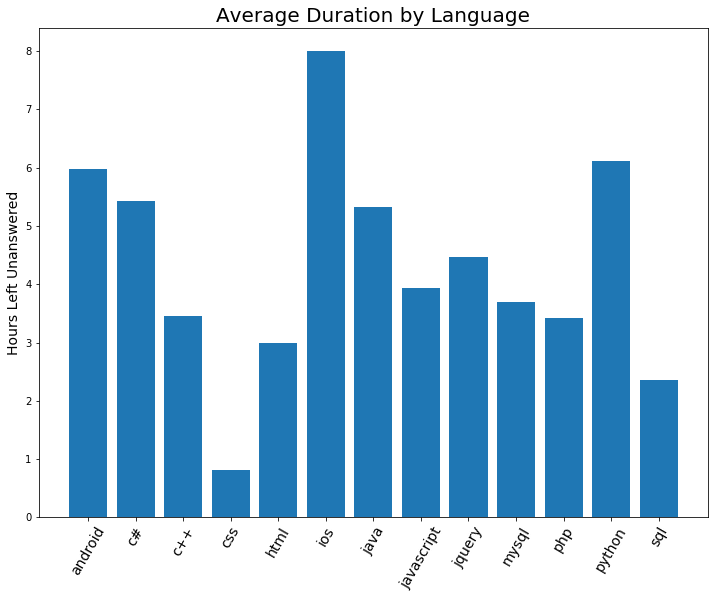

In [122]:
plt.bar(range(len(duration_counts)), duration_counts)
plt.title("Average Duration by Language", fontsize=20)
plt.xticks(range(len(vote_counts)), prog_languages, rotation='60', fontsize=14)
plt.ylabel('Hours Left Unanswered', fontsize=14)
plt.figure(figsize=(1,1))
plt.show()

If we break up languages based on the duration, we can see how long it takes for the questions to be answered. 

While Java is the most upvoted language, it's turn around time on answers is relatively quick. Meanwhile, python is one of the most upvoted languages, but it takes longer for python questions to be answered.

Interestingly, JavaScript gets more votes than jQuery, but the turn around for JavaScript is slightly faster. This may mean the demand for JavaScript questions to be answered is higher than that of jQuery. 

Also, remember how we saw that Android had the broadest set of users answering questions? Well, here we can see that android questions take the longest to answer! This contrasts Python, which has a smaller base of users answering the majority of the questions, but they are able to answer questiions faster on average than Android.

We also saw that CSS has one of the highest deviations from question to question, but here we can see that CSS questions are answered in a relatively short timeframe.

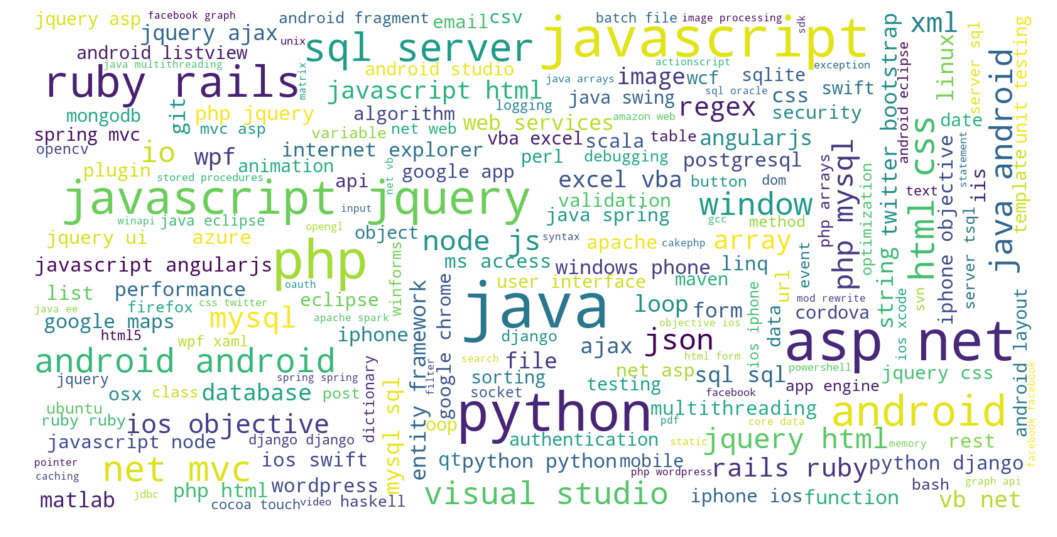

In [32]:
# https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
from wordcloud import WordCloud

wordcloud = WordCloud(
    background_color='white',
    width=1600,
    height=800,
    max_font_size=100).generate(' '.join(df_tags.Tag[ df_tags.Tag.notnull() ]))
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Lastly, if we generate a word cloud of the tags of each question, we can see that programming languages dominate the tags of a question.

The next set of noticable words are the frameworks built on top of popular languages: jQuery, Ruby on Rails, .NET, etc.